## Market Movement Prediction Strategy: Create Buy Signal from Forecasted Probability of Log Return Increase

### Written: Eddie Taylor


In [1]:
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense 
from tensorflow.keras.optimizers import Adam, RMSprop
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from matplotlib import style
import plotly.express as px 
import plotly.io as pio
pio.renderers.default = "notebook_connected"
style.use('dark_background')
pd.set_option('display.max_columns', None)

2022-02-26 14:12:04.173927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-26 14:12:04.173947: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/eddie/miniconda3/envs/securities-analysis/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[*********************100%***********************]  4 of 4 completed


<AxesSubplot:xlabel='Date'>

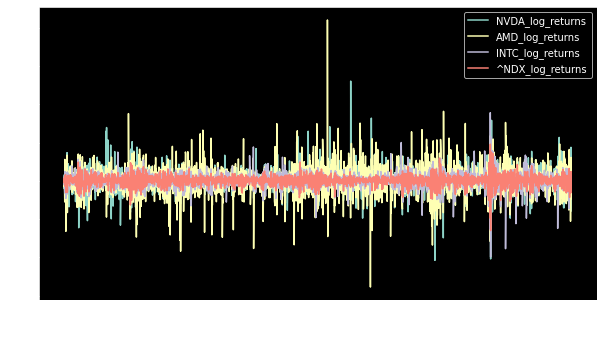

In [2]:
# Lets analyze Nvidia. We know from quick lookup of Nvidia news
# that Intel performance is connected to its performance, in addition to AMD.
# (source: https://www.barrons.com/articles/nvidia-intels-report-is-a-great-leading-indicator-says-raymond-james-1525724415)
# NDX is the index for the technology sector.
tickers = ['^NDX', 'INTC', 'AMD', 'NVDA']
data = (yf.download(tickers, start='2010-01-01', end='2022-02-18')
            .drop(columns = ['Close','Open','High','Low','Volume'])
)
data.columns = data.columns.droplevel()

for i in tickers:
    data[f'{i}_log_returns'] = (data[i].pct_change() + 1).apply(np.log)
data.tail()
data.plot(y=['NVDA_log_returns','AMD_log_returns','INTC_log_returns','^NDX_log_returns'], 
        use_index=True, figsize=(10,6))
# log returns quickly and efficiently detrends the pricing history

### **Feature Engineering**

#### Direction Feature

In [3]:
# lets define a direction column which is essentially 1 if the log return is positive and 0 if
# it is negative (classification tasks typically have a target variable which is 1 or 0)
for i in tickers:
    data[f'{i}_direction'] = np.where(data[f'{i}_log_returns'] > 0, 1, 0)

data.tail()

,AMD,INTC,NVDA,^NDX,^NDX_log_returns,INTC_log_returns,AMD_log_returns,NVDA_log_returns,^NDX_direction,INTC_direction,AMD_direction,NVDA_direction
Date,,,,,,,,,,,,
2022-02-11,113.180000,47.630001,239.490005,14253.839844,-0.031205,-0.025496,-0.105475,-0.075378,0,0,0,0
2022-02-14,114.269997,47.580002,242.669998,14268.589844,0.001034,-0.001050,0.009585,0.013191,1,0,1,1
2022-02-15,121.470001,48.439999,264.950012,14620.820312,0.024386,0.017913,0.061103,0.087839,1,1,1,1
2022-02-16,117.690002,48.230000,265.109985,14603.639648,-0.001176,-0.004345,-0.031613,0.000604,0,0,0,1
2022-02-17,112.370003,47.570000,245.070007,14171.740234,-0.030021,-0.013779,-0.046257,-0.078601,0,0,0,0


#### Lag Features

/home/eddie/miniconda3/envs/securities-analysis/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



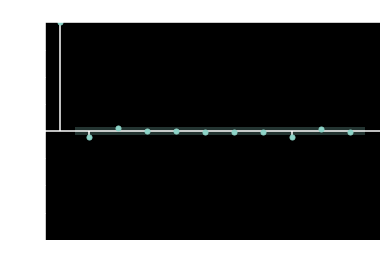

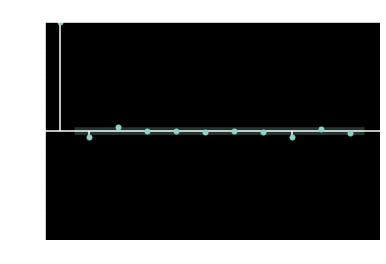

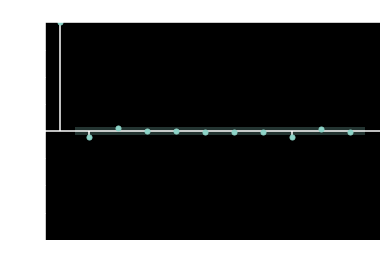

In [4]:
# traditionally to determine optimal lags of the target variable, we look at the autocorrelation 
# and partial autocorrelation of the target variable
plot_acf(data['NVDA_direction'], lags=10)
plot_pacf(data['NVDA_direction'], lags=10)

# looking at these plots, lagging the target variable probably won't help us

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	features = data.columns
	df = data
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(f'{j}(t-{i})') for j in features]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [(f'{j}') for j in features]
		else:
			names += [(f'{j}(t+{i})') for j in features]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# essentially build a forecast which predicts tomorrow. Excessive lagging of features but its fine because we can 
# examine the feature importance after modelling.
data = series_to_supervised(data)
data.tail()

,AMD(t-1),INTC(t-1),NVDA(t-1),^NDX(t-1),^NDX_log_returns(t-1),INTC_log_returns(t-1),AMD_log_returns(t-1),NVDA_log_returns(t-1),^NDX_direction(t-1),INTC_direction(t-1),AMD_direction(t-1),NVDA_direction(t-1),AMD,INTC,NVDA,^NDX,^NDX_log_returns,INTC_log_returns,AMD_log_returns,NVDA_log_returns,^NDX_direction,INTC_direction,AMD_direction,NVDA_direction
Date,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-11,125.769997,48.860001,258.239990,14705.639648,-0.023609,-0.021262,-0.054766,-0.033547,0.0,0.0,0.0,0.0,113.180000,47.630001,239.490005,14253.839844,-0.031205,-0.025496,-0.105475,-0.075378,0,0,0,0
2022-02-14,113.180000,47.630001,239.490005,14253.839844,-0.031205,-0.025496,-0.105475,-0.075378,0.0,0.0,0.0,0.0,114.269997,47.580002,242.669998,14268.589844,0.001034,-0.001050,0.009585,0.013191,1,0,1,1
2022-02-15,114.269997,47.580002,242.669998,14268.589844,0.001034,-0.001050,0.009585,0.013191,1.0,0.0,1.0,1.0,121.470001,48.439999,264.950012,14620.820312,0.024386,0.017913,0.061103,0.087839,1,1,1,1
2022-02-16,121.470001,48.439999,264.950012,14620.820312,0.024386,0.017913,0.061103,0.087839,1.0,1.0,1.0,1.0,117.690002,48.230000,265.109985,14603.639648,-0.001176,-0.004345,-0.031613,0.000604,0,0,0,1
2022-02-17,117.690002,48.230000,265.109985,14603.639648,-0.001176,-0.004345,-0.031613,0.000604,0.0,0.0,0.0,1.0,112.370003,47.570000,245.070007,14171.740234,-0.030021,-0.013779,-0.046257,-0.078601,0,0,0,0


#### Date Features

In [6]:
data.reset_index(inplace=True)
data['year'] = data.Date.dt.year
data['month'] = data.Date.dt.month 
data['day'] = data.Date.dt.day
data['week'] = data.Date.dt.isocalendar().week
data['quarterstart'] = data.Date.dt.is_quarter_start.astype(int)
data['quarterend'] = data.Date.dt.is_quarter_end.astype(int)
data['dow'] = data.Date.dt.dayofweek
data['quarter'] = data.Date.dt.quarter
data.set_index('Date', inplace=True)
data.head()

,AMD(t-1),INTC(t-1),NVDA(t-1),^NDX(t-1),^NDX_log_returns(t-1),INTC_log_returns(t-1),AMD_log_returns(t-1),NVDA_log_returns(t-1),^NDX_direction(t-1),INTC_direction(t-1),AMD_direction(t-1),NVDA_direction(t-1),AMD,INTC,NVDA,^NDX,^NDX_log_returns,INTC_log_returns,AMD_log_returns,NVDA_log_returns,^NDX_direction,INTC_direction,AMD_direction,NVDA_direction,year,month,day,week,quarterstart,quarterend,dow,quarter
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-06,9.71,14.459599,4.308282,1888.430054,0.000917,-0.000479,0.001030,0.014497,1.0,0.0,1.0,1.0,9.57,14.411101,4.335841,1878.420044,-0.005315,-0.003360,-0.014523,0.006376,0,0,0,1,2010,1,6,1,0,0,2,1
2010-01-07,9.57,14.411101,4.335841,1878.420044,-0.005315,-0.003360,-0.014523,0.006376,0.0,0.0,0.0,1.0,9.47,14.272535,4.250870,1876.719971,-0.000905,-0.009662,-0.010504,-0.019792,0,0,0,0,2010,1,7,1,0,0,3,1
2010-01-08,9.47,14.272535,4.250870,1876.719971,-0.000905,-0.009662,-0.010504,-0.019792,0.0,0.0,0.0,0.0,9.43,14.431888,4.260056,1892.589966,0.008421,0.011103,-0.004233,0.002159,1,1,0,1,2010,1,8,1,0,0,4,1
2010-01-11,9.43,14.431888,4.260056,1892.589966,0.008421,0.011103,-0.004233,0.002159,1.0,1.0,0.0,1.0,9.14,14.515030,4.200346,1886.239990,-0.003361,0.005744,-0.031236,-0.014116,0,1,0,0,2010,1,11,2,0,0,0,1
2010-01-12,9.14,14.515030,4.200346,1886.239990,-0.003361,0.005744,-0.031236,-0.014116,0.0,1.0,0.0,0.0,8.65,14.279459,4.057962,1861.790039,-0.013047,-0.016363,-0.055101,-0.034486,0,0,0,0,2010,1,12,2,0,0,1,1


#### Modelling

In [7]:
pd.options.plotting.backend = "plotly"

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np

models = {
    'bagging_classifier': BaggingClassifier(KNeighborsClassifier(),
                               max_samples=0.5, max_features=0.5),
    'random_forest' : RandomForestClassifier(n_estimators=10),
    'extra_trees' : ExtraTreesClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2),
    'ada_boost' : AdaBoostClassifier(n_estimators=100),
    'grad_boost' : GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1),
    #'light_gbm' : HistGradientBoostingClassifier(max_iter=100)

}

params = {'n_estimators': np.arange(100,500,100)}

target_variable = 'NVDA_direction'

# we don't want to randomly split the train and test because we're dealing with time series here
#x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.90, random_state=1234)

# can't have the target variable in the training set
#data.drop(columns='NVDA_log_returns', inplace=True)

def ensemble_models_fit_eval(models, data, params, target_variable, cutoff = '2020-01-01', long_short=True):

    X, y = data.loc[:, (data.columns != target_variable) & (data.columns != 'NVDA_log_returns')].copy(), data.loc[:, target_variable].copy()

    X_train, X_test = X[X.index < cutoff].copy(), X[X.index >= cutoff].copy()
    y_train, y_test = y[y.index < cutoff].copy(), y[y.index >= cutoff].copy()

    fit_models = dict()
    plot_cols = list()
    for model in models.keys():
        print(f"Begin cross-validated hyperparameter tuning fit for {model} \n")
        search = RandomizedSearchCV(models[model], scoring='accuracy', cv=5,
                            n_iter=10, param_distributions=params, n_jobs=-1)
        #print(X_train.columns)
        #print(y_train.columns)
        search.fit(X_train, y_train)
        print(f"Best cross-validated score: \n {search.best_score_} \n")
        print(f"Best parameters found: \n {search.best_params_} \n")
        clf = search.best_estimator_
        fit_models[model] = clf
        # generate position from prediction
        if long_short == True:
            # model outputs 1 and 0 but we want it to output
            # values of -1 (short) or 1 (long)
            data[f"{model}_pos"] = np.where(fit_models[model].predict(X) > 0, 1, -1)
        else:
            # will take on values of 0 (neutral) or 1 (long)
            data[f"{model}_pos"] = fit_models[model].predict(X)

        data[f"{model}_strategy"] = (data[f"{model}_pos"] * data[f'NVDA_log_returns'])
        plot_cols.append(f"{model}_strategy")

        # Print performance metrics
        aperf = np.exp(data[f"{model}_strategy"].sum())
        operf = aperf - np.exp(data['NVDA_log_returns'].sum())
        print(f"\nAbsolute Performance of {model}: {aperf} \n")
        print(f"\nOutperformance/Underperformance of {model} w.r.t buy&hold: {operf}\n")
        # convert to daily returns and then annualize
        ann_ret = (np.exp(data[f"{model}_strategy"]) - 1).mean() * 252
        ann_std = (np.exp(data[f"{model}_strategy"]) - 1).std() * np.sqrt(252)
        print(f"\nAnnualized Return = {ann_ret}\n")
        print(f"\nAnnualized Volatility = {ann_std}\n")
        print(f"\nSharpe Ratio = {ann_ret/ann_std}\n")
        print(f"\nNumber of Trades = {(data[f'{model}_pos'].diff()!=0).sum()}")
    # putting these columns at the end for easier inspection
    data.insert(len(data.columns)-1, f'{target_variable}', data.pop(f"{target_variable}"))
    data.insert(len(data.columns)-2, 'NVDA_log_returns', data.pop('NVDA_log_returns'))

    # plot performance on the holdout set
    plotting_data = data[['NVDA_log_returns'] + plot_cols][data.index >= cutoff].cumsum().apply(np.exp)
    fig = px.line(plotting_data, x=plotting_data.index, y=['NVDA_log_returns'] + plot_cols,
    title="Cumulative Gross Returns of Boosting Strategies",
    labels={'value':'Cumulative Gross Returns'})
    fig.show()
    return data, fit_models

cutoff = '2021-01-01'

data_strats, fit_models = ensemble_models_fit_eval(models=models, data=data, params=params, 
target_variable=target_variable, cutoff = cutoff, long_short=False)

Begin cross-validated hyperparameter tuning fit for bagging_classifier 



/home/eddie/miniconda3/envs/securities-analysis/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



Best cross-validated score: 
 0.4383879201728673 

Best parameters found: 
 {'n_estimators': 200} 


Absolute Performance of bagging_classifier: 221521583.44949013 


Outperformance/Underperformance of bagging_classifier w.r.t buy&hold: 221521526.56602404


Annualized Return = 1.6336472569329643


Annualized Volatility = 0.29599832211584615


Sharpe Ratio = 5.519109855945726


Number of Trades = 919
Begin cross-validated hyperparameter tuning fit for random_forest 



/home/eddie/miniconda3/envs/securities-analysis/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



Best cross-validated score: 
 0.6758651529889478 

Best parameters found: 
 {'n_estimators': 200} 


Absolute Performance of random_forest: 8906671632532.143 


Outperformance/Underperformance of random_forest w.r.t buy&hold: 8906671632475.26


Annualized Return = 2.512020144929828


Annualized Volatility = 0.28309488051188186


Sharpe Ratio = 8.873421308035258


Number of Trades = 1606
Begin cross-validated hyperparameter tuning fit for extra_trees 



/home/eddie/miniconda3/envs/securities-analysis/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



Best cross-validated score: 
 0.665012632114949 

Best parameters found: 
 {'n_estimators': 400} 


Absolute Performance of extra_trees: 8697697464603.587 


Outperformance/Underperformance of extra_trees w.r.t buy&hold: 8697697464546.703


Annualized Return = 2.5103111557460087


Annualized Volatility = 0.28404578427022087


Sharpe Ratio = 8.837699042763747


Number of Trades = 1604
Begin cross-validated hyperparameter tuning fit for ada_boost 



/home/eddie/miniconda3/envs/securities-analysis/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



Best cross-validated score: 
 0.6819599036434022 

Best parameters found: 
 {'n_estimators': 100} 


Absolute Performance of ada_boost: 7560987478.992155 


Outperformance/Underperformance of ada_boost w.r.t buy&hold: 7560987422.108689


Annualized Return = 1.9247172568749864


Annualized Volatility = 0.2879196926873909


Sharpe Ratio = 6.684910083468136


Number of Trades = 1543
Begin cross-validated hyperparameter tuning fit for grad_boost 



/home/eddie/miniconda3/envs/securities-analysis/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



Best cross-validated score: 
 0.6729411611100594 

Best parameters found: 
 {'n_estimators': 100} 


Absolute Performance of grad_boost: 18690486742.91294 


Outperformance/Underperformance of grad_boost w.r.t buy&hold: 18690486686.029476


Annualized Return = 2.000457117346283


Annualized Volatility = 0.2895433159699337


Sharpe Ratio = 6.909008106939036


Number of Trades = 1589


In [9]:
data

,AMD(t-1),INTC(t-1),NVDA(t-1),^NDX(t-1),^NDX_log_returns(t-1),INTC_log_returns(t-1),AMD_log_returns(t-1),NVDA_log_returns(t-1),^NDX_direction(t-1),INTC_direction(t-1),AMD_direction(t-1),NVDA_direction(t-1),AMD,INTC,NVDA,^NDX,^NDX_log_returns,INTC_log_returns,AMD_log_returns,^NDX_direction,INTC_direction,AMD_direction,year,month,day,week,quarterstart,quarterend,dow,quarter,bagging_classifier_pos,bagging_classifier_strategy,random_forest_pos,random_forest_strategy,extra_trees_pos,extra_trees_strategy,ada_boost_pos,ada_boost_strategy,grad_boost_pos,grad_boost_strategy,NVDA_log_returns,NVDA_direction
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-06,9.710000,14.459599,4.308282,1888.430054,0.000917,-0.000479,0.001030,0.014497,1.0,0.0,1.0,1.0,9.570000,14.411101,4.335841,1878.420044,-0.005315,-0.003360,-0.014523,0,0,0,2010,1,6,1,0,0,2,1,0,0.0,1,0.006376,1,0.006376,0,0.000000,0,0.000000,0.006376,1
2010-01-07,9.570000,14.411101,4.335841,1878.420044,-0.005315,-0.003360,-0.014523,0.006376,0.0,0.0,0.0,1.0,9.470000,14.272535,4.250870,1876.719971,-0.000905,-0.009662,-0.010504,0,0,0,2010,1,7,1,0,0,3,1,0,-0.0,0,-0.000000,0,-0.000000,0,-0.000000,0,-0.000000,-0.019792,0
2010-01-08,9.470000,14.272535,4.250870,1876.719971,-0.000905,-0.009662,-0.010504,-0.019792,0.0,0.0,0.0,0.0,9.430000,14.431888,4.260056,1892.589966,0.008421,0.011103,-0.004233,1,1,0,2010,1,8,1,0,0,4,1,0,0.0,1,0.002159,1,0.002159,1,0.002159,1,0.002159,0.002159,1
2010-01-11,9.430000,14.431888,4.260056,1892.589966,0.008421,0.011103,-0.004233,0.002159,1.0,1.0,0.0,1.0,9.140000,14.515030,4.200346,1886.239990,-0.003361,0.005744,-0.031236,0,1,0,2010,1,11,2,0,0,0,1,0,-0.0,0,-0.000000,0,-0.000000,0,-0.000000,0,-0.000000,-0.014116,0
2010-01-12,9.140000,14.515030,4.200346,1886.239990,-0.003361,0.005744,-0.031236,-0.014116,0.0,1.0,0.0,0.0,8.650000,14.279459,4.057962,1861.790039,-0.013047,-0.016363,-0.055101,0,0,0,2010,1,12,2,0,0,1,1,0,-0.0,0,-0.000000,0,-0.000000,0,-0.000000,0,-0.000000,-0.034486,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,125.769997,48.860001,258.239990,14705.639648,-0.023609,-0.021262,-0.054766,-0.033547,0.0,0.0,0.0,0.0,113.180000,47.630001,239.490005,14253.839844,-0.031205,-0.025496,-0.105475,0,0,0,2022,2,11,6,0,0,4,1,0,-0.0,0,-0.000000,0,-0.000000,0,-0.000000,0,-0.000000,-0.075378,0
2022-02-14,113.180000,47.630001,239.490005,14253.839844,-0.031205,-0.025496,-0.105475,-0.075378,0.0,0.0,0.0,0.0,114.269997,47.580002,242.669998,14268.589844,0.001034,-0.001050,0.009585,1,0,1,2022,2,14,7,0,0,0,1,0,0.0,1,0.013191,1,0.013191,0,0.000000,0,0.000000,0.013191,1
2022-02-15,114.269997,47.580002,242.669998,14268.589844,0.001034,-0.001050,0.009585,0.013191,1.0,0.0,1.0,1.0,121.470001,48.439999,264.950012,14620.820312,0.024386,0.017913,0.061103,1,1,1,2022,2,15,7,0,0,1,1,0,0.0,1,0.087839,1,0.087839,1,0.087839,1,0.087839,0.087839,1


In [10]:
data[['NVDA_log_returns'] + [i + '_strategy' for i in fit_models.keys()]].loc[data.index >= cutoff,:].cumsum().apply(np.exp).plot()


### Event-based Backtest

In [17]:
import backtrader as bt
from backtrader.feeds import PandasData

prices = yf.download('NVDA', start='2010-01-01', end='2022-02-18')
prices.drop(columns='Close', inplace=True)
prices.rename(columns={'Open':'open','High':'high','Low':'low',
'Adj Close':'close','Volume':'volume'}, inplace=True)
prices.head()

# join the position to this
position = data[['extra_trees_pos']].copy()
position.rename(columns={'extra_trees_pos':'predicted'}, inplace=True)
# without specifying columns joins on index
prices = prices.join(position, how='inner')
prices.head()

OHLCV = ['open', 'high', 'low', 'close', 'volume']# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']# create lines
    lines = tuple(cols)# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None    # logging function

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')    
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')        # set no pending order
        self.order = None    
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted == 1:
                # calculate the max number of shares (general rule of not risking
                # more than 1% of trading account)
                size = int((.50 * self.broker.getcash() / self.datas[0].open))
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted == 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

[*********************100%***********************]  1 of 1 completed


In [20]:
# see docs: https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed/
# of course, lets see performance on holdout set
data_bt = SignalData(dataname=prices[prices.index >= cutoff])

# watch out for this cheat on open parameter. Look up in docs. 
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data_bt, name='NVDA')
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2021-01-05, BUY CREATED --- Size: 381, Cash: 100000.00, Open: 130.99749755859375, Close: 133.93051147460938
2021-01-05, BUY EXECUTED --- Price: 131.00, Cost: 49910.05,Commission: 49.91
2021-01-06, SELL CREATED --- Size: 381
2021-01-06, SELL EXECUTED --- Price: 132.23, Cost: 49910.05,Commission: 50.38
2021-01-06, OPERATION RESULT --- Gross: 467.68, Net: 367.39
2021-01-07, BUY CREATED --- Size: 386, Cash: 100367.39, Open: 129.6750030517578, Close: 133.3235626220703
2021-01-07, BUY EXECUTED --- Price: 129.68, Cost: 50054.55,Commission: 50.05
2021-01-12, SELL CREATED --- Size: 386
2021-01-12, SELL EXECUTED --- Price: 137.52, Cost: 50054.55,Commission: 53.08
2021-01-12, OPERATION RESULT --- Gross: 3030.10, Net: 2926.96
2021-01-13, BUY CREATED --- Size: 382, Cash: 103294.35, Open: 134.89999389648438, Close: 135.1994171142578
2021-01-13, BUY EXECUTED --- Price: 134.90, Cost: 51531.80,Commission: 51.53
2021-01-14, SELL CREATED --- Size: 382
2021-01-14, SELL 